In [1]:
import pandas as pd
from casanovo.casanovo import setup_logging, setup_model, ModelRunner
import torch.nn as nn
import numpy as np
from casanovo.denovo.model import Spec2Pep
import collections
import heapq
import logging
import warnings
from typing import Any, Dict, Iterable, List, Optional, Tuple, Union

import depthcharge.masses
import einops
import torch
import numpy as np
from tqdm import tqdm
import lightning.pytorch as pl
from torch.utils.tensorboard import SummaryWriter
from depthcharge.components import ModelMixin, PeptideDecoder, SpectrumEncoder
import seaborn as sns
from pathlib import Path
from matplotlib import pyplot as plt

from captum.attr import IntegratedGradients

2024-09-11 15:40:36.226901: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-11 15:40:36.234602: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-11 15:40:36.236843: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-11 15:40:36.242669: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-11 15:40:36.639034: W tensorflow/com

In [25]:
path_output = ""
peak_path = (
    Path(
        "/home/samva/Doctorate/data_directory/denovo_project/mgf_filtered/F01_Fraction1.mgf"
    ),
)
verbosity = "info" # Default value
path_model = Path("/home/samva/Doctorate/data_directory/denovo_project/checkpoints/casanovo/casanovo_massivekb.ckpt")
path_config = Path("/home/samva/Doctorate/DeNovo_Benchmark/configs/casanovo/casanovo.yaml")

output = setup_logging(path_output, verbosity)
config, model = setup_model(path_model, path_config, output, False)


with ModelRunner(config, model) as runner:

    runner.initialize_trainer(train=False)
    runner.initialize_model(train=False)
    model_pt = runner.model
    test_index = runner._get_index(peak_path, False, "")
    runner.initialize_trainer(train=False)
    runner.initialize_data_module(test_index=test_index)
    runner.loaders.setup(stage="test", annotated=False)

    dl = runner.loaders._make_loader(
        runner.loaders.test_dataset,
        50
    )
    dtp = []
    for x in dl:
        dtp.append(x)

index_spectra = {p[2][0][1]: i for i, p in enumerate(dtp)}

Seed set to 454
INFO: Casanovo version 4.2.0
INFO: Casanovo version 4.2.0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
INFO: Reading 1 files...
INFO: Reading 1 files...
/home/samva/Doctorate/data_directory/denovo_project/mgf_filtered/F01_Fraction1.mgf: 9157spectra [00:01, 4906.26spectra/s]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [3]:
class InterpretableCasanovo(nn.Module):
    def __init__(self, model: Spec2Pep):
        super().__init__()
        self.encoder = model.encoder
        self.decoder = model.decoder
        self.softmax = model.softmax
        self.max_length = model.max_length
        self.n_beams = model.n_beams
        self.model = model

    def forward(self, spectra, precursors, peptide=None, apply_softmax=False):
        
        memories, mem_masks = self.encoder(spectra)

        if peptide is None:
            pred, _ = self.decoder(None, precursors, memories, mem_masks)
        else:
            pred, _ = self.decoder([peptide], precursors, memories, mem_masks)
        
        if apply_softmax:
            pred = self.softmax(pred)
        return pred
    
    def decompose_inputs(self, combined_tensor):
        # Find the indices of the padding (inf) markers
        padding_indices = (combined_tensor == float('inf')).nonzero(as_tuple=True)[0]
        
        # Extract each part by splitting at the padding indices
        input1_flat = combined_tensor[:padding_indices[0]]
        input2_flat = combined_tensor[padding_indices[0]+1:padding_indices[1]]
        input3_flat = combined_tensor[padding_indices[1]+1:]
        print(combined_tensor.shape, input1_flat.shape, input2_flat.shape, input3_flat.shape)
        # Reshape input1 and input2 back to their original dimensions
        input1_size = input1_flat.size(0) // 2  # Determine original dynamic size for input1
        input2_size = input2_flat.size(0)  # Original size for input2
        
        spectra = input1_flat.view(1, input1_size, 2)  # Reshape to (1, input1_size, 2)
        precursors = input2_flat.view(1, input2_size)  # Reshape to (1, input2_size)
        peptide = input3_flat.view(-1)  # Reshape to (13) or whatever size it originally was
        
        return spectra, precursors, peptide

In [21]:
def extract_latent_spectrum(
        model,
        spectrum
):
    latent, mask = model.encoder(spectrum)
    return latent.detach().numpy()[:, 0, :]

In [4]:
model_pt_interpretable = InterpretableCasanovo(model_pt)

In [28]:
latent_spectra = []

for inp in tqdm(dtp):
    spectrum = inp[0]
    latent_spectra.append(
        extract_latent_spectrum(
            model=model_pt,
            spectrum=spectrum
        )
    )

100%|██████████| 184/184 [53:40<00:00, 17.50s/it]


In [37]:
dfs = []

for latent_batch in latent_spectra:
    dfs.append(pd.DataFrame(latent_batch))

In [39]:
latent_spectra_df = pd.concat(dfs)

In [40]:
from sklearn.manifold import TSNE

In [54]:
tsne = TSNE()
tsne_comp = tsne.fit_transform(latent_spectra_df)

In [55]:
tsne_df = pd.DataFrame(tsne_comp)

In [57]:
tsne_df

,0,1
0,61.335476,68.930298
1,60.600208,67.299873
2,61.297512,68.952614
3,61.395466,67.609856
4,60.791019,67.861542
...,...,...
9152,-49.316059,-25.767134
9153,44.117718,-55.249481
9154,-37.680412,-37.077148
9155,-19.271965,68.507797


In [70]:
pepmass_charge = [d[1] for d in dtp]
pepmass_charge_matrix = pd.concat(pd.DataFrame(x) for x in pepmass_charge)

In [77]:
pepmass_charge_matrix = pepmass_charge_matrix.rename(columns={0:"pepmass", 1:"charge", 2:"mz"})

In [81]:
tsne_table = pd.concat([tsne_df, pepmass_charge_matrix.reset_index(drop=True)], axis=1)

<Axes: xlabel='0', ylabel='1'>

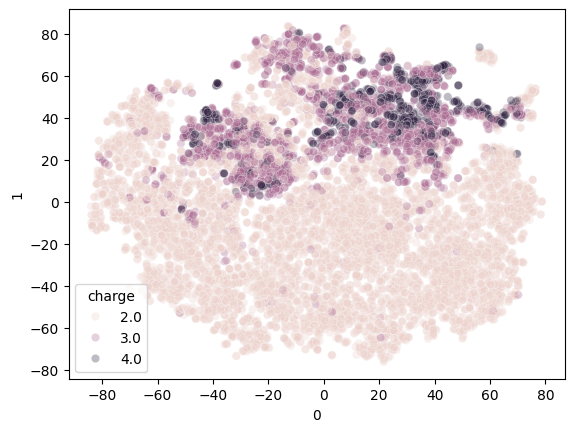

In [84]:
sns.scatterplot(
    tsne_table,
    x=0,
    y=1,
    hue="charge",
    alpha=.3
)

<Axes: xlabel='0', ylabel='1'>

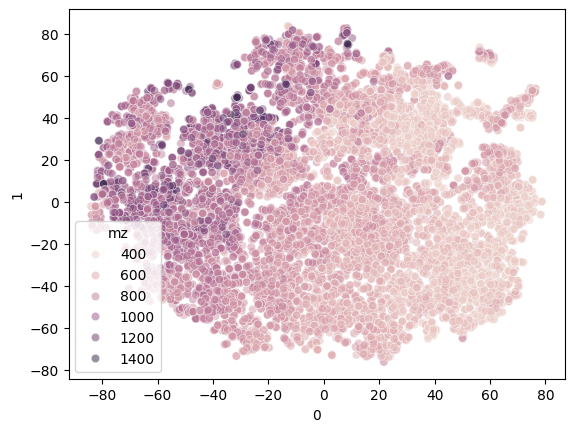

In [87]:
sns.scatterplot(
    tsne_table,
    x=0,
    y=1,
    hue="mz",
    alpha=.5
)

<Axes: ylabel='Count'>

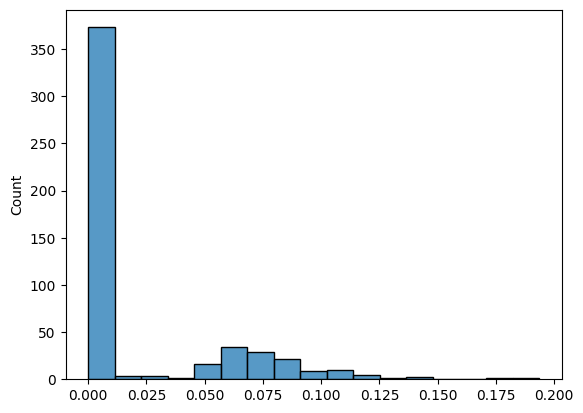

In [53]:
# Most features are the same...
sns.histplot(latent_spectra_df.std())

What about the AA embeddings

In [92]:
model_pt.decoder._aa2idx

{'G': 1,
 'A': 2,
 'S': 3,
 'P': 4,
 'V': 5,
 'T': 6,
 'C+57.021': 7,
 'L': 8,
 'I': 9,
 'N': 10,
 'D': 11,
 'Q': 12,
 'K': 13,
 'E': 14,
 'M': 15,
 'H': 16,
 'F': 17,
 'R': 18,
 'Y': 19,
 'W': 20,
 'M+15.995': 21,
 'N+0.984': 22,
 'Q+0.984': 23,
 '+42.011': 24,
 '+43.006': 25,
 '-17.027': 26,
 '+43.006-17.027': 27,
 '$': 28}

In [104]:
aa_embeddings = []
i_aa_dict = {}

for i, (aa, idx) in enumerate(model_pt.decoder._aa2idx.items()):
    aa_embeddings.append(model_pt.decoder.aa_encoder(
            torch.tensor([idx])
        ).detach().numpy()[0]
    )
    i_aa_dict[i] = aa

In [105]:
aa_embedding_df = pd.DataFrame(aa_embeddings).T.rename(columns=i_aa_dict)

<Axes: >

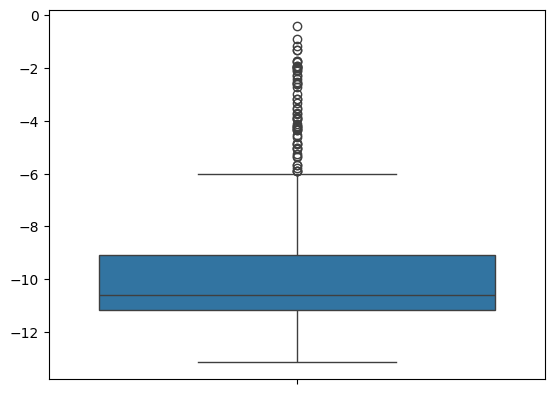

In [117]:
sns.boxplot(np.log(aa_embedding_df.T.var()))

In [127]:
reduced_embedding_matrix = aa_embedding_df.loc[aa_embedding_df.T.var()>np.exp(-6), :].T

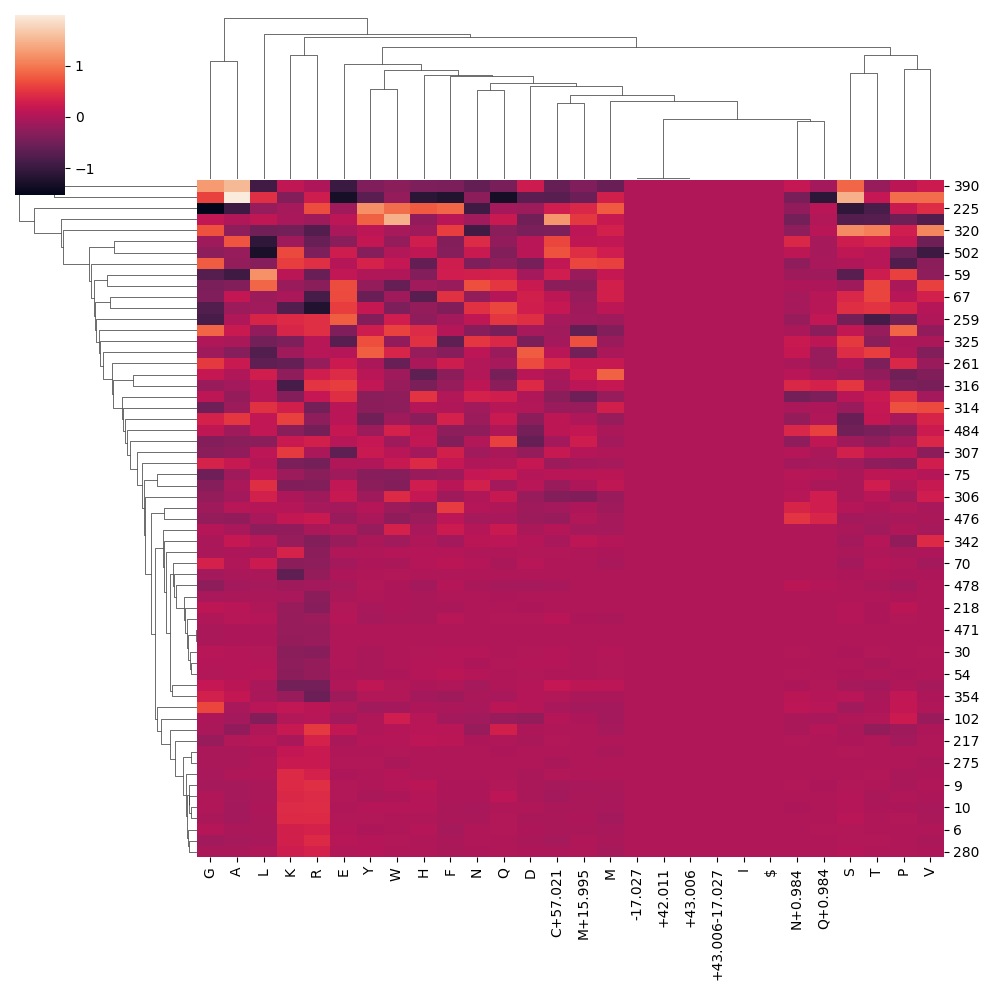

In [128]:
sns.clustermap(reduced_embedding_matrix.T)